# Setup

In [1]:
!pip install torch torchvision torchaudio
!pip install gymnasium==0.29.1
!pip install minatar==1.0.15
!pip install matplotlib
!pip install imageio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 49.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import copy
import numpy as np
import pandas as pd
import random
from PIL import Image
import gymnasium as gym
import matplotlib.pyplot as plt
from typing import Callable
from collections import namedtuple
import itertools

# Defining the DQN network

In [3]:
class DuelingDQN(nn.Module):
    def __init__(self, obs_shape: torch.Size, num_actions: int):
        super(DuelingDQN, self).__init__()

        # Shared feature extractor
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.conv_out_size = self.calculate_conv_output_shape(obs_shape)

        # Value stream
        self.value_stream = nn.Sequential(
            nn.Linear(self.conv_out_size, 256),
            nn.ReLU(),
            nn.Linear(256, 1)  # Output V(s)
        )

        # Advantage stream
        self.advantage_stream = nn.Sequential(
            nn.Linear(self.conv_out_size, 256),
            nn.ReLU(),
            nn.Linear(256, num_actions)  # Output A(s, a)
        )

    def calculate_conv_output_shape(self,obs_shape):

      with torch.no_grad():

        if len(obs_shape) == 3:
          obs_shape = (1, *obs_shape)

        x = torch.zeros(*obs_shape)
        x = x.permute(0, 3, 1, 2)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        conv_out_size = x.shape[1]

      return conv_out_size

    def forward(self, x):

      x = x.permute(0, 3, 1, 2)
      features = F.relu(self.conv1(x))
      features = F.relu(self.conv2(features))
      features = F.relu(self.conv3(features))
      features = torch.flatten(features, start_dim=1)
      value = self.value_stream(features)  # V(s)
      advantage = self.advantage_stream(features)  # A(s, a)

      # Combine value and advantage to get Q-values
      q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
      return q_values


# Defining the epsilon-greedy policy

In [4]:
def make_epsilon_greedy_policy(Q1: nn.Module, num_actions: int):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon. Taken from last exercise with changes.

    :param Q: The DQN network.
    :param num_actions: Number of actions in the environment.

    :returns: A function that takes the observation as an argument and returns the greedy action in form of an int.
    """

    def policy_fn(obs: torch.Tensor, epsilon: float = 0.0):
        """This function takes in the observation and returns an action."""

        if np.random.uniform() < epsilon:
            return np.random.randint(0, num_actions) # Returning a random action for exploring

        with torch.no_grad():
          return (Q1(obs)).argmax().detach().numpy()  # Returning the greedy action

    return policy_fn

In [5]:
def linear_epsilon_decay(eps_start: float, eps_end: float, current_timestep: int, duration: int) -> float:
    """
    Linear decay of epsilon.

    :param eps_start: The initial epsilon value.
    :param eps_end: The final epsilon value.
    :param current_timestep: The current timestep.
    :param duration: The duration of the schedule (in timesteps). So when schedule_duration == current_timestep, eps_end should be reached

    :returns: The current epsilon.
    """

    if current_timestep >= duration:
        return eps_end

    epsilon = eps_start - (eps_start - eps_end) * (current_timestep / duration)

    return max(eps_end, epsilon)  # Ensure epsilon doesn't go below eps_end

# The replay buffer

In [6]:
class ReplayBuffer:
    def __init__(self, max_size: int):
        """
        Create the replay buffer.

        :param max_size: Maximum number of transitions in the buffer.
        """
        self.data = []
        self.max_size = max_size
        self.position = 0

    def __len__(self) -> int:
        """Returns how many transitions are currently in the buffer."""

        return len(self.data)

    def store(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor, next_obs: torch.Tensor, terminated: torch.Tensor):
        """
        Adds a new transition to the buffer. When the buffer is full, overwrite the oldest transition.

        :param obs: The current observation.
        :param action: The action.
        :param reward: The reward.
        :param next_obs: The next observation.
        :param terminated: Whether the episode terminated.
        """

        transition = (obs, action, reward, next_obs, terminated)
        if len(self.data) < self.max_size:
            self.data.append(transition)
            self.position = (self.position + 1) % self.max_size
        else:
          self.data[self.position] = transition

    def sample(self, batch_size: int) -> torch.Tensor:
        """
        Sample a batch of transitions uniformly and with replacement. The respective elements e.g. states, actions, rewards etc. are stacked

        :param batch_size: The batch size.
        :returns: A tuple of tensors (obs_batch, action_batch, reward_batch, next_obs_batch, terminated_batch), where each tensors is stacked.
        """
        batch = random.choices(self.data, k=batch_size) #sampling with replacement

        obs_batch, action_batch, reward_batch, next_obs_batch, terminated_batch = zip(*batch)

        obs_batch = torch.stack(obs_batch)
        action_batch = torch.stack(action_batch)
        reward_batch = torch.stack(reward_batch)
        next_obs_batch = torch.stack(next_obs_batch)
        terminated_batch = torch.stack(terminated_batch)

        return obs_batch, action_batch, reward_batch, next_obs_batch, terminated_batch

# The Update function

In [7]:
def update_dqn(
        q: nn.Module,
        q_target: nn.Module,
        optimizer: optim.Optimizer,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
    ):
    """
    Update the DQN network for one optimizer step.

    :param q: The DQN network.
    :param q_target: The target DQN network.
    :param optimizer: The optimizer.
    :param gamma: The discount factor.
    :param obs: Batch of current observations.
    :param act: Batch of actions.
    :param rew: Batch of rewards.
    :param next_obs: Batch of next observations.
    :param tm: Batch of termination flags.

    """
    # TODO: Zero out the gradient
    optimizer.zero_grad()

    # TODO: Calculate the TD-Target
    with torch.no_grad():
        next_q_value = q_target(next_obs).max(dim=1)[0]
        td_target = rew + (gamma * next_q_value)

    # TODO: Calculate the loss. Hint: Pytorch has the ".gather()" function, which collects values along a specified axis using some specified indexes
    current_q_value = q(obs).gather(1, act.unsqueeze(1))

    loss = nn.MSELoss()(current_q_value, td_target.unsqueeze(1))

    # TODO: Backpropagate the loss and step the optimizer
    loss.backward()
    optimizer.step()

# The DQN Agent

In [12]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])


class DQNAgent:
  def __init__(self,
          env,
          gamma=0.99,
          lr=0.001,
          batch_size=64,
          eps_start=1.0,
          eps_end=0.1,
          schedule_duration=10_000,
          update_freq=100,
          maxlen=100_000,
      ):
      """
      Initialize the DQN agent.

      :param env: The environment.
      :param gamma: The discount factor.
      :param lr: The learning rate.
      :param batch_size: Mini batch size.
      :param eps_start: The initial epsilon value.
      :param eps_end: The final epsilon value.
      :param schedule_duration: The duration of the schedule (in timesteps).
      :param update_freq: How often to update the Q target.
      :param max_size: Maximum number of transitions in the buffer.
      """

      self.env = env
      self.gamma = gamma
      self.batch_size = batch_size
      self.eps_start = eps_start
      self.eps_end = eps_end
      self.schedule_duration = schedule_duration
      self.update_freq = update_freq

      self.replay_buffer = ReplayBuffer(max_size=maxlen)

      self.q = DuelingDQN(env.observation_space.shape, env.action_space.n)

      self.q_target = DuelingDQN(env.observation_space.shape, env.action_space.n)

      self.q_target.load_state_dict(copy.deepcopy(self.q.state_dict()))

      self.optimizer = optim.Adam(self.q.parameters(), lr=lr)

      self.policy = make_epsilon_greedy_policy(self.q, env.action_space.n)


  def train(self, num_episodes: int) -> EpisodeStats:
      """
      Train the DQN agent.

      :param num_episodes: Number of episodes to train.
      :returns: The episode statistics.
      """

      # Keeps track of useful statistics
      stats = EpisodeStats(
          episode_lengths=np.zeros(num_episodes),
          episode_rewards=np.zeros(num_episodes),
      )

      current_timestep = 0
      epsilon = self.eps_start

      for i_episode in range(num_episodes):
          # Print out which episode we're on, useful for debugging.
          if (i_episode + 1) % 100 == 0:
              print(f'Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}  Epsilon: {epsilon:.3f}')

          # Reset the environment and get initial observation
          obs, _ = self.env.reset()

          for episode_time in itertools.count():

              # Get current epsilon value
              epsilon = linear_epsilon_decay(self.eps_start, self.eps_end, current_timestep, self.schedule_duration)

              # Choose action and execute
              action = self.policy(torch.as_tensor(obs).unsqueeze(0).float(), epsilon=epsilon)
              next_obs, reward, terminated, truncated, _ = self.env.step(action)

              # Update statistics
              stats.episode_rewards[i_episode] += reward
              stats.episode_lengths[i_episode] += 1

              # Store sample in the replay buffer
              self.replay_buffer.store(torch.tensor(obs), torch.tensor(action), torch.tensor(reward), torch.tensor(next_obs), torch.tensor(terminated))

              # Sample a mini batch from the replay buffer
              obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch = self.replay_buffer.sample(self.batch_size)
              # obs_batch = [16,10,10,4] , act_batch = [16] ,  rew_batch = [16] , next_obs_batch  = [16,10,10,4] , tm_batch = [16]

              # Update the Q network
              update_dqn(
                  self.q,
                  self.q_target,
                  self.optimizer,
                  self.gamma,
                  obs_batch.float(),
                  act_batch,
                  rew_batch.float(),
                  next_obs_batch.float(),
                  tm_batch
              )

              # Update the current Q target
              if current_timestep % self.update_freq == 0:
                  self.q_target.load_state_dict(self.q.state_dict())
              current_timestep += 1

              # Check whether the episode is finished
              if terminated or truncated or episode_time >= 500:
                  break
              obs = next_obs

      return stats

# Training

In [20]:
# Choose your environment
env = gym.make('MinAtar/Breakout-v1', render_mode="rgb_array")

# Print observation and action space infos
print(f"Training on {env.spec.id}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}\n")

# Hyperparameters, Hint: Change as you see fit
LR = 0.001
BATCH_SIZE = 16
REPLAY_BUFFER_SIZE = 200_000
UPDATE_FREQ = 1000
EPS_START = 0.8
EPS_END = 0.2
SCHEDULE_DURATION = 15_000
NUM_EPISODES = 2000
DISCOUNT_FACTOR = 0.99

# Train DQN
agent = DQNAgent(
    env,
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
)
stats = agent.train(NUM_EPISODES)

Training on MinAtar/Breakout-v1
Observation space: Box(False, True, (10, 10, 4), bool)
Action space: Discrete(3)

Episode 100 of 2000  Time Step: 1032  Epsilon: 0.759
Episode 200 of 2000  Time Step: 2204  Epsilon: 0.712
Episode 300 of 2000  Time Step: 3642  Epsilon: 0.654
Episode 400 of 2000  Time Step: 5158  Epsilon: 0.594
Episode 500 of 2000  Time Step: 6698  Epsilon: 0.532
Episode 600 of 2000  Time Step: 8598  Epsilon: 0.456
Episode 700 of 2000  Time Step: 10850  Epsilon: 0.366
Episode 800 of 2000  Time Step: 13710  Epsilon: 0.252
Episode 900 of 2000  Time Step: 16980  Epsilon: 0.200
Episode 1000 of 2000  Time Step: 19368  Epsilon: 0.200
Episode 1100 of 2000  Time Step: 22296  Epsilon: 0.200
Episode 1200 of 2000  Time Step: 24904  Epsilon: 0.200
Episode 1300 of 2000  Time Step: 27942  Epsilon: 0.200
Episode 1400 of 2000  Time Step: 31062  Epsilon: 0.200
Episode 1500 of 2000  Time Step: 34444  Epsilon: 0.200
Episode 1600 of 2000  Time Step: 37898  Epsilon: 0.200
Episode 1700 of 2000 

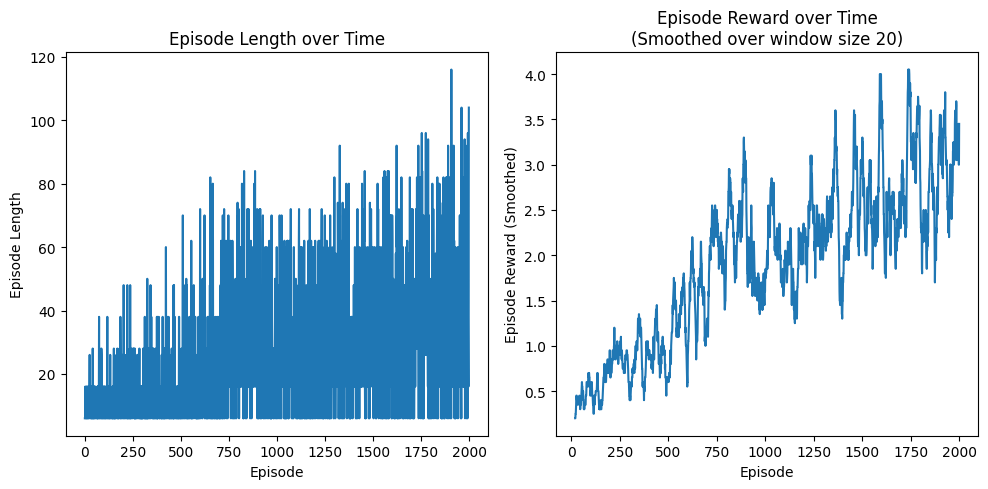

In [21]:
smoothing_window=20
fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

# Plot the episode length over time
ax = axes[0]
ax.plot(stats.episode_lengths)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Length")
ax.set_title("Episode Length over Time")

# Plot the episode reward over time
ax = axes[1]
rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
ax.plot(rewards_smoothed)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Reward (Smoothed)")
ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")
plt.show()

/usr/local/lib/python3.11/dist-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/utils/passive_env_checker.py:276: UserWarning: WARN: RGB-array rendering should return a numpy array with dtype uint8, got float64
  logger.warn(


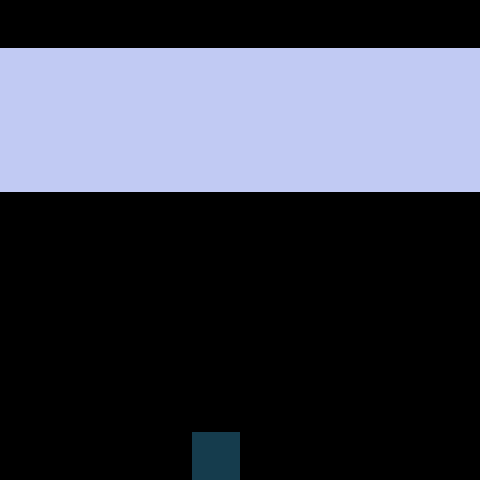

In [22]:
from IPython.display import Image as IImage

def save_rgb_animation(rgb_arrays, filename, duration=50):
    """Save an animated GIF from a list of RGB arrays."""
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array*255).astype(np.uint8)
        rgb_array = rgb_array.repeat(48, axis=0).repeat(48, axis=1)
        img = Image.fromarray(rgb_array)
        frames.append(img)

    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=2_000):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]

    for _ in range(max_steps):
        action = policy(torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0))
        obs, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())

        if terminated or truncated:
            break

    return imgs

policy = make_epsilon_greedy_policy(agent.q_target, num_actions=env.action_space.n)
imgs = rendered_rollout(policy, env)
save_rgb_animation(imgs, "trained.gif")
IImage(filename="trained.gif")